In [116]:
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [117]:
words = open('/Users/raghx/Desktop/Neural Networks/makemore/names.txt','r',).read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [118]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_length = len(itos)
      

In [119]:
#Dataset Creation
def build_dataset(words):
    X = []
    Y = []
    block_size = 3
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y


In [120]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_tr,Y_tr = build_dataset(words[:n1])
X_val,Y_val = build_dataset(words[n1:n2])
X_test,Y_test = build_dataset(words[n2:])


In [121]:
n_embedding = 10
n_hidden = 200
block_size = 3 
g = torch.Generator().manual_seed(3332321)
C = torch.randn(((vocab_length,n_embedding)),generator=g)
w1 = torch.randn((n_embedding * block_size,n_hidden),generator=g) * ((2)/((n_embedding * block_size) ** 0.5))       # kamimi init for relu
# b1 = torch.randn(n_hidden,generator=g) * 0.001    # bias not used because we have batch normal layer's bias(bn_bias)
w2 = torch.randn((n_hidden,vocab_length),generator=g) * 0.01
b2 = torch.randn(vocab_length,generator=g) * 0
bn_gain = torch.ones(1,n_hidden)
bn_bias = torch.zeros(1,n_hidden)
bn_running_mean = torch.zeros(1,n_hidden)
bn_running_std = torch.ones(1,n_hidden)
params = [C,w1,w2,b2,bn_bias,bn_gain]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

12097


In [122]:
#forward pass
batch_size = 32 
max_steps = 30000
loss_i =[]
momentum = 0.99
for k in range(max_steps):
    ikx = torch.randint(0,X_tr.shape[0],(batch_size,),generator=g)
    embd = C[X_tr[ikx]]
    a_pre_activation = embd.view(embd.shape[0],-1) @ w1 #b1
#batch normalization    
    meani =  a_pre_activation.mean(0,keepdim=True)
    stdi = a_pre_activation.std(0,keepdim=True)
    a_pre_activation = bn_gain * ((a_pre_activation - meani)/(0.00001 + stdi )) + bn_bias    
    with torch.no_grad():
        bn_running_mean = momentum * bn_running_mean + 0.01 * meani
        bn_running_std = momentum * bn_running_std + 0.01 * stdi
#activations for hidden layer
    a = torch.relu(a_pre_activation)
#Output layer    
    logits = a @ w2 + b2
    loss = F.cross_entropy(logits,Y_tr[ikx])
#backward pass
    for p in params:
        p.grad = None
    loss.backward()
    lr = 0.001 if k > 10000 else 0.1
    for p in params:
        p.data += -lr * p.grad

    if k % 5000 == 0:
        print(f'{k}/{max_steps}:{loss.item()}')

    loss_i.append(loss.item())

0/30000:3.302718162536621
5000/30000:2.090196371078491
10000/30000:2.218991756439209
15000/30000:1.9394466876983643
20000/30000:1.9241738319396973
25000/30000:2.2006077766418457


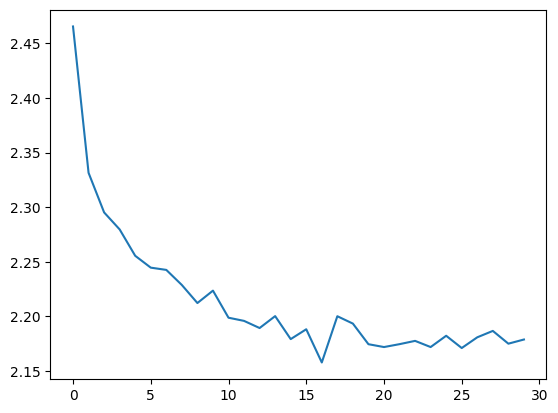

In [123]:
plt.plot(torch.tensor(loss_i).view(-1,1000).mean(1))

In [124]:
#Inference 
@torch.no_grad()
def Split_loss(split):
    x,y = {
        'train': (X_tr,Y_tr),
        'val': (X_val,Y_val),
        'test': (X_test,Y_test)
    }[split]
    embd = C[x]
    a_pre_activation = embd.view(embd.shape[0],-1) @ w1 # + b1
    a_pre_activation = bn_gain * ((a_pre_activation - bn_running_mean)/(0.00001 + bn_running_std)) + bn_bias
    a = torch.relu(a_pre_activation)
    logits = a @ w2 + b2
    loss = F.cross_entropy(logits,y)
    return loss.item()

print("Training loss",Split_loss('train'))
print("Validation loss",Split_loss('val'))

Training loss 2.1474430561065674
Validation loss 2.4052257537841797


In [125]:
# -> Original initial loss
# Training loss 25.325109481811523
# Validation loss 25.109655380249023

# -> after fixing initial loss by reducing bias and weights value for reducing output logits value
# Training loss 3.897186756134033
# Validation loss 3.88931941986084

# -> fixing tanh problem by reducing b1 and w1
# Training loss 2.1027655601501465
# Validation loss 2.3686301708221436

In [126]:
def build_dataset(words):
    X = []
    Y = []
    block_size = 8
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X,Y

In [127]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_tr,Y_tr = build_dataset(words[:n1])
X_val,Y_val = build_dataset(words[n1:n2])
X_test,Y_test = build_dataset(words[n2:])

In [128]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [129]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C = torch.randn((vocab_length, n_embd),            generator=g)
model  = Sequential([
  Embedding(vocab_length, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_length),
])
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


45597


In [130]:
max_steps = 150000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_tr.shape[0], (batch_size,))
  Xb, Yb = X_tr[ix], Y_tr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 150000: 3.3150
  10000/ 150000: 2.0820
  20000/ 150000: 2.4330
  30000/ 150000: 2.4384
  40000/ 150000: 1.8213
  50000/ 150000: 1.8812
  60000/ 150000: 2.5303
  70000/ 150000: 2.2004
  80000/ 150000: 1.7139
  90000/ 150000: 1.5114
 100000/ 150000: 2.1220
 110000/ 150000: 1.7197
 120000/ 150000: 1.6200
 130000/ 150000: 2.1496
 140000/ 150000: 1.8119


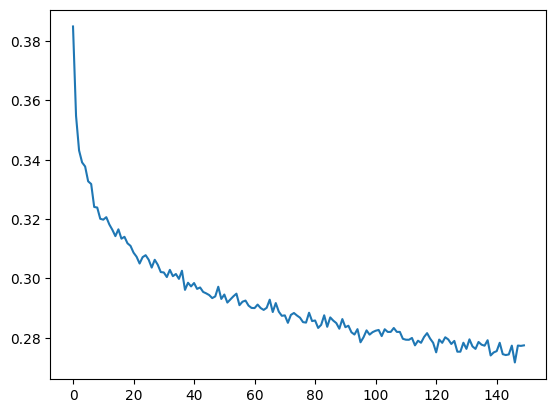

In [131]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [132]:
for layer in model.layers:
  layer.training = False

In [133]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (X_tr, Y_tr),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.8751704692840576
val 2.291152000427246


In [134]:
# train 1.8227760791778564
# val 2.2209994792938232

# train 1.7881035804748535
# val 2.225564479827881


In [135]:
# sample from the model
block_size = 8
for _ in range(40):
    
    out = []
    context = [0] * block_size# initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

kola.
hezbs.
mey.
senas.
shuana.
carol.
haydne.
hil.
kathana.
kyltara.
demoni.
khara.
naiassak.
busla.
erchamola.
zayo.
nayeya.
bryoor.
kier.
zalaniyah.
nevoria.
kriya.
mikennley.
aarrout.
joliyah.
linna.
raelee.
mamar.
khirah.
leerell.
que.
dilynne.
jaxon.
serder.
leanna.
simuida.
britol.
niko.
abina.
narvell.
